In [1]:
import os
import platform
from IPython.display import clear_output
print(platform.platform())

def resolve_dir(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)

def reset_path(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)
    else:
        os.system('rm -f {}/*'.format( Dir))

Windows-10-10.0.22621-SP0


In [2]:
import tensorflow as tf
tf.random.set_seed(73)
TPU_INIT = False

if TPU_INIT:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
        tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime!')
else:
    !nvidia-smi
;    
print("Tensorflow version " + tf.__version__)


Tensorflow version 2.15.0


'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


## **Preprocessing**
+ **Getting frames form video**
+ **some image argumentations**

In [3]:
!pip install imageio


Defaulting to user installation because normal site-packages is not writeable


In [4]:
import cv2
import os
import imageio
import imgaug.augmenters as iaa
import imgaug as ia

IMG_SIZE = 128
ColorChannels = 3

def video_to_frames(video):
    vidcap = cv2.VideoCapture(video)
    
    import math
    rate = math.floor(vidcap.get(3))
    count = 0
    
    ImageFrames = []
    while vidcap.isOpened():
        ID = vidcap.get(1)
        success, image = vidcap.read()
        
        if success:
            # skipping frames to avoid duplications 
            if (ID % 7 == 0):
                flip = iaa.Fliplr(1.0)
                zoom = iaa.Affine(scale=1.3)
                random_brightness = iaa.Multiply((1, 1.3))
                rotate = iaa.Affine(rotate=(-25, 25))
                
                image_aug = flip(image = image)
                image_aug = random_brightness(image = image_aug)
                image_aug = zoom(image = image_aug)
                image_aug = rotate(image = image_aug)
                
                rgb_img = cv2.cvtColor(image_aug, cv2.COLOR_BGR2RGB)
                resized = cv2.resize(rgb_img, (IMG_SIZE, IMG_SIZE))
                ImageFrames.append(resized)
                
            count += 1
        else:
            break
    
    vidcap.release()
    
    return ImageFrames

v2

In [5]:
import numpy as np
from tqdm import tqdm

# Initialize lists to store data
X_original_list = []
y_original_list = []

VideoDataDir = r'C:\Users\keswa\Desktop\24 mini prjct\data'

# Get the list of subdirectories in VideoDataDir
subdirectories = os.listdir(VideoDataDir)

# Initialize variables to store the counts of videos
num_violence_videos = 0
num_nonviolence_videos = 0

# Iterate over the subdirectories
for category in subdirectories:
    # Construct the full path to the subdirectory
    path = os.path.join(VideoDataDir, category)
    # Check if the path is a directory
    if os.path.isdir(path):
        # Get the class label based on the subdirectory name
        if category.lower() == 'vio':
            class_label = 1  # Violence class
            num_violence_videos += len(os.listdir(path))
        elif category.lower() == 'nvio':
            class_label = 0  # Non-violence class
            num_nonviolence_videos += len(os.listdir(path))
        else:
            continue  # Skip directories that are not labeled 'vio' or 'nvio'

        # Iterate over the videos in the subdirectory
        for video in tqdm(os.listdir(path)):
            # Process each video and extract frames
            frames = video_to_frames(os.path.join(path, video))
            # Add frames and corresponding class labels to X_original_list and y_original_list
            for frame in frames:
                X_original_list.append(frame)
                y_original_list.append(class_label)

print('Total Violence videos:', num_violence_videos)
print('Total NonViolence videos:', num_nonviolence_videos)

# Convert lists to NumPy arrays
X_original = np.array(X_original_list)
y_original = np.array(y_original_list)


  0%|          | 0/39 [00:00<?, ?it/s]

100%|██████████| 97/97 [00:35<00:00,  2.72it/s]


Total Violence videos: 97
Total NonViolence videos: 39


In [11]:
%%time
from tqdm import tqdm

VideoDataDir = r'C:\Users\keswa\Desktop\24 mini prjct\data'

violence_dir = r'C:\Users\keswa\Desktop\24 mini prjct\data\Violence'
non_violence_dir = r'C:\Users\keswa\Desktop\24 mini prjct\data\NonViolence'

print('we have \n{} Violence videos \n{} NonViolence videos'.format(len(os.listdir(os.path.join(VideoDataDir, violence_dir))), len(os.listdir(os.path.join(VideoDataDir, non_violence_dir)))))

X_original = []
y_original = []

print('i choose 700 videos out of 2000, cuz of memory issue')
CLASSES = ["NonViolence", "Violence"]
# 700 <- 350 + 350

for category in os.listdir(VideoDataDir):
    path = os.path.join(VideoDataDir, category)
    class_num = CLASSES.index(category)
    for i, video in enumerate(tqdm(os.listdir(path)[0:])):
        frames = video_to_frames(os.path.join(path, video))
        for j, frame in enumerate(frames):
            X_original.append(frame)
            y_original.append(class_num)


we have 
97 Violence videos 
40 NonViolence videos
i choose 700 videos out of 2000, cuz of memory issue


100%|██████████| 97/97 [00:39<00:00,  2.47it/s]

CPU times: total: 32.2 s
Wall time: 1min 5s


In [13]:
import numpy as np
X_original = np.array(X_original).reshape(-1 , IMG_SIZE * IMG_SIZE * 3)
y_original = np.array(y_original)
len(X_original)

2561

In [12]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

stratified_sample = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=73)

for train_index, test_index in stratified_sample.split(X_original, y_original):
    X_train, X_test = X_original[train_index], X_original[test_index]
    y_train, y_test = y_original[train_index], y_original[test_index]

X_train_nn = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255
X_test_nn = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255

## **Model Training**

In [21]:
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [22]:
!pip install imutils
clear_output()

In [23]:
!pip install keras

Defaulting to user installation because normal site-packages is not writeable


In [24]:
import cv2
import os
import numpy as np
import pickle
import matplotlib
matplotlib.use("Agg")
from keras.models import Model
from keras.layers import Input,Dropout,Flatten,Dense


import matplotlib.pyplot as plt

In [25]:
!pip install timm

Defaulting to user installation because normal site-packages is not writeable


In [26]:
from keras import backend as K
from timm.models import mobilenetv3_large_100

import torch

def load_layers():
    input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, ColorChannels))
    
    # Load MobileNetV3 model
    baseModel = mobilenetv3_large_100(pretrained=True, num_classes=1, in_chans=ColorChannels)
    
    # Convert Keras tensor to PyTorch tensor
    x = torch.tensor(K.eval(input_tensor))
    
    # Remove the include_top argument
    
    headModel = baseModel.forward_features(x)
    headModel = Dense(1, activation="sigmoid")(headModel)
    model = Model(inputs=input_tensor, outputs=headModel)

    # Don't freeze the layers for fine-tuning
    
    print("Compiling model...")
    model.compile(loss="binary_crossentropy",
                    optimizer='adam',
                    metrics=["accuracy"])

    return model


In [30]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


working netv3

In [39]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import numpy as np


def load_layers():
  
  IMG_SIZE = 128  # Define your image size
  ColorChannels = 3  # Define number of color channels (e.g., 3 for RGB)

  input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, ColorChannels))

  # Load MobileNetV3Large pre-trained model with 1 output class
  base_model = MobileNetV3Large(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, ColorChannels))

  # Freeze base model layers for fine-tuning
  base_model.trainable = False

  # Add a Dense layer for binary classification
  head_model = base_model(input_tensor)
  head_model = Dense(1, activation="sigmoid")(head_model)
  model = Model(inputs=input_tensor, outputs=head_model)

  model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

  return model

model = load_layers()
model.summary()



12683000/12683000 [==============================] - 3s 0us/step

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 MobilenetV3large (Function  (None, 4, 4, 960)         2996352   
 al)                                                             
                                                                 
 dense (Dense)               (None, 4, 4, 1)           961       
                                                                 
Total params: 2997313 (11.43 MB)
Trainable params: 961 (3.75 KB)
Non-trainable params: 2996352 (11.43 MB)
_________________________________________________________________


In [40]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

patience = 3

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005

batch_size = 4

if TPU_INIT:
    max_lr = max_lr * tpu_strategy.num_replicas_in_sync
    batch_size = batch_size * tpu_strategy.num_replicas_in_sync

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if ((logs.get('accuracy')>=0.999)):
            print("\nLimits Reached cancelling training!")
            self.model.stop_training = True

In [42]:
end_callback = myCallback()

lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

early_stopping = EarlyStopping(patience = patience, monitor='val_loss',
                                 mode='min', restore_best_weights=True, 
                                 verbose = 1, min_delta = .00075)

PROJECT_DIR =r'C:\Users\keswa\Desktop\24 mini prjct'

lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')

os.system('rm -rf ./logs/')

import datetime
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir = log_dir, write_graph=True, histogram_freq=1)

checkpoint_filepath = 'Model3Weights.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)


callbacks = [end_callback, lr_callback, model_checkpoints, tensorboard_callback, early_stopping, lr_plat]

if TPU_INIT:
    callbacks = [end_callback, lr_callback, model_checkpoints, early_stopping, lr_plat]

In [44]:
print('X_train_nn shape:', X_train_nn.shape)
print('y_train shape:', y_train.shape)


X_train_nn shape: (1792, 128, 128, 3)
y_train shape: (1792,)


In [43]:
print('Training head...')
#model.load_weights('./Model_Weights.h5')

history = model.fit(X_train_nn ,y_train, epochs=epochs,
                        callbacks=callbacks,
                        validation_data = (X_test_nn, y_test),
                        batch_size=batch_size)

print('\nRestoring best Weights for MobileNetV2')
model.load_weights(checkpoint_filepath)

Training head...
Epoch 1/5


ValueError: in user code:

    File "C:\Users\keswa\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\keswa\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\keswa\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\keswa\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\keswa\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "C:\Users\keswa\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\keswa\AppData\Roaming\Python\Python311\site-packages\keras\src\losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\keswa\AppData\Roaming\Python\Python311\site-packages\keras\src\losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\keswa\AppData\Roaming\Python\Python311\site-packages\keras\src\losses.py", line 2532, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "C:\Users\keswa\AppData\Roaming\Python\Python311\site-packages\keras\src\backend.py", line 5822, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((4, 4, 4, 1) vs (4,)).


In [ ]:
%matplotlib inline

def print_graph(item, index, history):
    plt.figure()
    train_values = history.history[item][0:index]
    plt.plot(train_values)
    test_values = history.history['val_' + item][0:index]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)


def get_best_epoch(test_loss, history):
    for key, item in enumerate(history.history.items()):
        (name, arr) = item
        if name == 'val_loss':
            for i in range(len(arr)):
                if round(test_loss, 2) == round(arr[i], 2):
                    return i
                
def model_summary(model, history):
    print('---'*30)
    test_loss, test_accuracy = model.evaluate(X_test_nn, y_test, verbose=0)

    if history:
        index = get_best_epoch(test_loss, history)
        print('Best Epochs: ', index)

        train_accuracy = history.history['accuracy'][index]
        train_loss = history.history['loss'][index]

        print('Accuracy on train:',train_accuracy,'\tLoss on train:',train_loss)
        print('Accuracy on test:',test_accuracy,'\tLoss on test:',test_loss)
        print_graph('loss', index, history)
        print_graph('accuracy', index, history)
        print('---'*30)                

------------------------------------------------------------------------------------------
Best Epochs:  31
Accuracy on train: 0.9616789817810059 	Loss on train: 0.11210563778877258
Accuracy on test: 0.9577874541282654 	Loss on test: 0.116333968937397


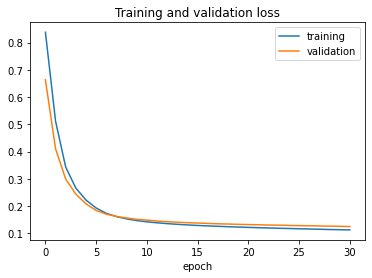

<Figure size 432x288 with 0 Axes>

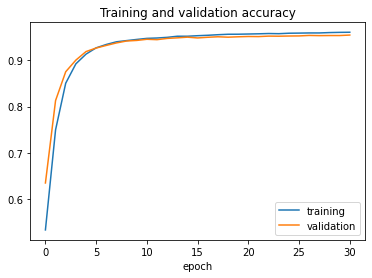

------------------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [ ]:
model_summary(model, history)

## **Evaluation on test set**

In [ ]:
# evaluate the network
print("Evaluating network...")
predictions = model.predict(X_test_nn)
preds = predictions > 0.5

Evaluating network...


C:\Users\hp\AppData\Local\Temp/ipykernel_6244/3180812836.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_correct = np.int((corr_pred[0][0] + corr_pred[1][1]))
C:\Users\hp\AppData\Local\Temp/ipykernel_6244/3180812836.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

> Correct Predictions: 4606
> Wrong Predictions: 203


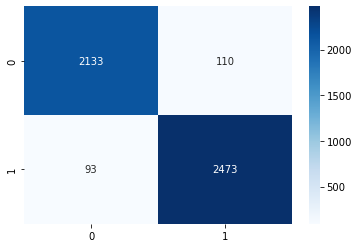

              precision    recall  f1-score   support

 NonViolence       0.96      0.95      0.95      2243
    Violence       0.96      0.96      0.96      2566

    accuracy                           0.96      4809
   macro avg       0.96      0.96      0.96      4809
weighted avg       0.96      0.96      0.96      4809



In [ ]:
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, accuracy_score, classification_report, confusion_matrix
corr_pred = metrics.confusion_matrix(y_test, preds)

n_correct = np.int((corr_pred[0][0] + corr_pred[1][1]))
print('> Correct Predictions:', n_correct)
n_wrongs = np.int((corr_pred[0][1] + (corr_pred[1][0])))
print('> Wrong Predictions:', n_wrongs)

sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Blues")
plt.show()

print(metrics.classification_report(y_test, preds, 
                           target_names=["NonViolence", "Violence"]))

In [ ]:
args_model = "modelnew.h5"
model.save(args_model)